# Generate digit images like MNIST dataset images using GANs

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preparation

In [7]:
def get_images():
  # import dataset (comes with colab!)
  data = np.loadtxt( open('sample_data/mnist_train_small.csv','rb'), delimiter=',' )

  # don't need the labels here
  data = data[:, 1:]

  # normalize the data to a range of [-1 1] (b/c tanh output)
  dataNorm = data / np.max(data)
  dataNorm = 2 * dataNorm - 1

  # convert to tensor
  dataT = torch.tensor( dataNorm ).float()

  return dataT

In [8]:
# no dataloaders!
batchsize = 100

## Discriminator Model

In [9]:
class DiscriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear( 28 * 28, 256 )
    self.fc2 = nn.Linear( 256, 256 )
    self.output = nn.Linear( 256, 1 )

  def forward(self, data):
    data = F.leaky_relu( self.fc1(data) )
    data = F.leaky_relu( self.fc2(data) )

    return torch.sigmoid( self.output(data) )

In [10]:
# test run model
dnet = DiscriminatorNet()
y = dnet( torch.rand(10, 784) )
y.shape

torch.Size([10, 1])

## Generator Model

In [11]:
class GeneratorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear( 64, 256 )
    self.fc2 = nn.Linear( 256, 256 )
    self.output = nn.Linear( 256, 784 )

  def forward(self, data):
    data = F.leaky_relu( self.fc1(data) )
    data = F.leaky_relu( self.fc2(data) )

    return torch.tanh( self.output(data) )

In [12]:
# test run model
gnet = GeneratorNet()
y = gnet( torch.rand(10, 64) )
y.shape

torch.Size([10, 784])

## Model training function

1. use large training epochs with small learning rate
2. train disciminator to let it know the real images
3. train disciminator to let it know the fake images
4. combine loss from above 2 train then backprop to disciminator model
5. generate fake images from with generator
6. compute loss by telling the discriminator that generated fake images are real
7. backprop loss to generator model
8. repeat from (2) until training epochs

In [13]:
def train_model():
  dataT = get_images()

  # loss function (same for both phases of training)
  lossfun = nn.BCELoss()

  # create instances of the models
  dnet = DiscriminatorNet().to(device)
  gnet = GeneratorNet().to(device)

  # optimizers (same algo but different variables b/c different parameters)
  d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
  g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

  num_epochs = 50000

  losses  = np.zeros((num_epochs, 2))
  disDecs = np.zeros((num_epochs, 2)) # disDecs = discriminator decisions

  for epochi in range(num_epochs):

    # create minibatches of REAL and FAKE images
    randidx     = torch.randint(dataT.shape[0], (batchsize, ))
    real_images = dataT[randidx, :].to(device)
    fake_images = gnet( torch.randn(batchsize, 64).to(device) ) # output of generator


    # labels used for real and fake images
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)


    ### ---------------- Phase 1: Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(real_images)               # REAL images into discriminator
    d_loss_real = lossfun(pred_real, real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    pred_fake   = dnet(fake_images)               # FAKE images into discriminator
    d_loss_fake = lossfun(pred_fake, fake_labels) # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[epochi, 0]  = d_loss.item()
    disDecs[epochi, 0] = torch.mean( (pred_real > .5).float() ).detach()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    ### ---------------- Phase 2: Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize, 64).to(device) )
    pred_fake   = dnet( fake_images )

    # compute and collect loss and accuracy
    g_loss = lossfun(pred_fake, real_labels) # here we are using real labels for getting error of fake images
    losses[epochi, 1]  = g_loss.item()
    disDecs[epochi, 1] = torch.mean((pred_fake > .5).float()).detach()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # print out a status message
    if (epochi + 1) % 500==0:
      msg = f'Finished epoch {epochi+1} / {num_epochs}'
      sys.stdout.write('\r' + msg)

  return losses, disDecs, dnet, gnet

## Lets run the expriment

In [14]:
losses, disDecs, _, gnet = train_model()

Finished epoch 50000 / 50000

In [15]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

## Visualize the image generated by `GeneratorNet`

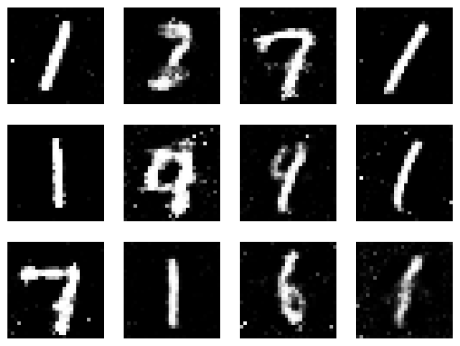

In [16]:
# generate the fake images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()